# CBDC ABM Simulation

This notebook contains a simulation for a toy economy that consists of a number of households, firms, banks, a clearing house and a central bank. Households are employed at firms, are paid wages for labour, produce output and purchase output. Wages are paid and output is paid for using deposits at banks. Deposits are cleared using a clearing system with batched payments or via a rapid payments system.

## Configuring the model

The parameter_values below can be specified for different simulations.

In [11]:
import xml.etree.ElementTree as ET

Below you will find the parameter inputs for this model. Change the parameter values for different configurations of the model.

In [12]:
parameter_values = (('num_sweeps', '31'),
                    ('num_simulations', '10'),
                    ('num_households', '150'),
                    ('num_firms', '12'),
                    ('num_banks', '4'),
                    ('num_ach', '1'),
                    ('num_central_bank', '1'),
                    ('batch', '2'),
                    ('interest_rate_list', 'deposits,loans,open_market_operations,loans_central_bank,interbank_deposits'),
                    ('reserves_interest', '0.00'),
                    ('loans_central_bank_interest', '0.012714883'),
                    ('open_market_operations_interest', '0.027135331'),
                    ('loans_interbank_interest', '0.012636397'),
                    ('loans_interest', '0.021721038'),
                    ('deposits_interest', '0.008762862'),
                    ('clearing_house_fee', '466666'),
                    ('household_directory', 'agents/gen_households/'),
                    ('firm_directory', 'agents/gen_firms/'),
                    ('bank_directory', 'agents/gen_banks/'),
                    ('ach_directory', 'agents/ach/'),
                    ('central_bank_directory', 'agents/central_bank/'),
                    ('measurement_config', 'measurements/test_measurements.xml')
                   )

To translate this to an xml document, which the framework can read, we first need create an ET element. 

In [13]:
environment = ET.Element('environment', identifier = "CBDC_parameters")

And create parameter elements and give them the values seen below to add to the tree object.

In [14]:
parameters = []
for x in range(len(parameter_values)):
    parameters.append(ET.SubElement(environment, 'parameter'))
    
for idx, p in enumerate(parameters):
    p.set('type', 'static')
    p.set('name', parameter_values[idx][0])
    p.set('value', parameter_values[idx][1])

This object can now be transformed to a string and written to an xml file using the code below. 

In [15]:
xml_params = ET.tostring(environment, encoding="UTF-8")
myfile = open("environments/CBDC_parameters.xml", "w")
xml_params = "<?xml version='1.0' encoding='UTF-8'?>\n" + str(xml_params, encoding = "UTF-8")
myfile.write(xml_params)
myfile.close()

Now, the parameter xml file has been generated and the model can be run. Before, running the model, you need to import a couple of extra modules. These are the Python logging module, the Black Rhino environment class, and the Black Rhino runner class.

In [16]:
import logging
import os
from src.environment import Environment
from src.runner import Runner

Then, before running the model, the logger needs to be initialized.

In [17]:
log_directory = "log/"
identifier = "/CBDC_parameters"
environment_directory = "environments/"
if not os.path.exists('log'):
    os.makedirs('log')
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    filename=log_directory + identifier + ".log", level=logging.INFO)
logging.info('START logging for run: %s',  environment_directory + identifier + ".xml")

Generate banks and households using the generate agents class. First remove any agents still in directories. Then generate agents, the number of households and banks needs to be specified. In the generate banks method, the number of banks is the second argument. In the generate households method, the number of households it the second argument and the number of banks is the thrid argument.

In [18]:
import os
remove = True

bank_dir = os.getcwd()+'/agents/gen_banks/'
house_dir = os.getcwd()+'/agents/gen_households/'
firm_dir = os.getcwd()+'/agents/gen_firms/'
if remove:
    bank_list = [ f for f in os.listdir(bank_dir) if f.startswith("bank") ]
    house_list = [ f for f in os.listdir(house_dir) if f.startswith("house") ]
    firm_list = [ f for f in os.listdir(firm_dir) if f.startswith("firm") ]
for f in bank_list:
    os.remove(os.path.join(bank_dir, f))
for f in house_list:
    os.remove(os.path.join(house_dir, f))
for f in firm_list:
    os.remove(os.path.join(firm_dir, f))

In [19]:
from src.br_generate_agents import Generate_Agents
gen_agents = Generate_Agents()

gen_agents.generate_households(parameter_values[2][1], "./agents/gen_households/")

gen_agents.generate_firms(parameter_values[3][1], "./agents/gen_firms/")

gen_agents.generate_banks(parameter_values[4][1], "./agents/gen_banks/")

First, the environment will be initialized. It contains the model parameters and variables. The environment also contains a list of agents. In the Solow model, the environment contains one bank, one firm, and one household. Finally, it also contains initialized transactions for these agents.

In [20]:
environment = Environment(environment_directory, identifier)


Create xml for measurements. First create template, then read in different accounts of interest for different agents, finally read in general variables of interest. NB running the general measurements closes the xml file. 

In [21]:
from src.br_measurements import Generate_Measurements
gen_measurements = Generate_Measurements()

general_accounts = ["total_output", "number_of_deposits", "clearing_house_fee_total", "number_of_batched_payments", "number_of_cleared_payments"]
gen_measurements.generate_measurements(general_accounts, "./measurements/test_measurements")



Next up, the runner object is created. As the name suggests, the runner object handles the running of the model. But that is not all, it also initializes the updater.

In [23]:
runner = Runner(environment)

Now you can actually run the model. Since the agent-based model is simulated using Monte Carlo methods. This means that the model will be run multiple times (num_simulations). For every simulation run, the environment and runner will be (re-)initialized. Then, the runner will run the Solow model. During the run, the runner will write data about capital to a csv file specified within the Measurement class and print out all the transactions happening and the books of firm and household at the end of each sweep.

In [24]:
for i in range(int(environment.num_simulations)):
    logging.info('  STARTED with run %s',  str(i))
    environment.initialize(environment_directory,  identifier)
    runner.initialize(environment)
    
    runner.do_run(environment)
    logging.info('  DONE')

measurements/test_measurements.xml
Period 0 complete
measurements/test_measurements.xml
3854938167.1204143 interest paid
Period 1 complete
measurements/test_measurements.xml
3987842053.9303975 interest paid
Period 2 complete
measurements/test_measurements.xml
4125760395.59677 interest paid
Period 3 complete
measurements/test_measurements.xml
4266342016.5838637 interest paid
Period 4 complete
measurements/test_measurements.xml
4416392998.287887 interest paid
Period 5 complete
measurements/test_measurements.xml
4575586623.514185 interest paid
Period 6 complete
measurements/test_measurements.xml
4740370069.409713 interest paid
Period 7 complete
measurements/test_measurements.xml
4917171317.851822 interest paid
Period 8 complete
measurements/test_measurements.xml
5100949863.463966 interest paid
Period 9 complete
measurements/test_measurements.xml
5293021471.550306 interest paid
Period 10 complete
measurements/test_measurements.xml


Check to see if all agents balance sheets are consistent. Rounding erros may result in not all agents having consistent balance sheets.

In [ ]:
npv = 0.0
wealth = 0.0
for houses in environment.households:
    npv += houses.check_npv()[houses.identifier]["npv"]
    wealth += houses.wealth

print(f"Household NPV is {round(npv, 2)} and wealth is {wealth}")

firm = True
for firms in environment.firms:
    firm *= firms.check_consistency()
if firm:
    print("All firms have consistent balance sheets")
else:
    print("Not all firms have consistent balance sheets")

bank = True
for banks in environment.banks:
    bank *= banks.check_consistency()
if bank:
    print("All banks have consistent balance sheets")
else:
    print("Not all banks have consistent balance sheets")

if environment.ach[0].check_consistency():
    print("ACH has consistent balance sheets")
elif environment.ach[0].check_consistency() is False:
    print("ACH does not consistent balance sheets")

print(f"Central Bank reserves are {environment.central_bank[0].get_account('reserves')}")

# if environment.central_bank[0].check_consistency():
#     print("Central Bank has consistent balance sheets")
# elif environment.central_bank[0].check_consistency() is False:
#     print("Central Bank does not consistent balance sheets")

Household NPV is 8915517833.0 and wealth is 7886871243.0
All firms have consistent balance sheets
All banks have consistent balance sheets
ACH has consistent balance sheets
Central Bank reserves are 148270167.1836988


Print Balance Sheet for one randomly selected household, firm and bank, and central bank.

In [ ]:
import pandas as pd
from functools import reduce

balance_b = []
for agent in environment.banks:
    balance_sheet = agent.balance_sheet()
    agent_bal = pd.DataFrame.from_dict(balance_sheet[agent.identifier], orient="columns")
    agent_bal.rename({"ach_payee_" + agent.identifier : "ach_payee", "ach_payer_" + agent.identifier : "ach_payer"}, inplace=True)
    agent_bal.rename({"loans_interbank_" + agent.identifier : "loans_interbank"}, inplace=True)
    agent_bal.loc['Total'] = round(agent_bal.sum(), 0)
    balance_b.append(agent_bal)

print("Total Bank Balance Sheet")
bank_balance = round(reduce(lambda x, y: x.add(y, fill_value=0), balance_b), 6)
print(bank_balance)

balance_sheet_ach = environment.ach[0].balance_sheet()
ach_bal = pd.DataFrame.from_dict(balance_sheet_ach["ach"], orient="columns")
ach_bal.loc['Total']= round(ach_bal.sum(), 0)
print("ACH Balance Sheet")
print(ach_bal)

balance_f = []
for agent in environment.firms:
    balance_sheet = agent.balance_sheet()
    agent_bal = pd.DataFrame.from_dict(balance_sheet[agent.identifier], orient="columns")
    agent_bal.loc['Total']= round(agent_bal.sum(), 0)
    balance_f.append(agent_bal)

print("Total Firm Balance Sheet")
firm_balance = reduce(lambda x, y: x.add(y, fill_value=0), balance_f)
print(firm_balance)

balance_h = []
for agent in environment.households:
    balance_sheet = agent.balance_sheet()
    agent_bal = pd.DataFrame.from_dict(balance_sheet[agent.identifier], orient="columns")
    agent_bal.loc['Total']= round(agent_bal.sum(), 0)
    balance_h.append(agent_bal)

print("Total Household Balance Sheet")
house_balance = reduce(lambda x, y: x.add(y, fill_value=0), balance_h)
print(house_balance)

balance_sheet_cb = environment.central_bank[0].balance_sheet()
central_bank_bal = pd.DataFrame.from_dict(balance_sheet_cb["central_bank"], orient="columns")
central_bank_bal.loc['Total']= round(central_bank_bal.sum(), 0)
print("Central Bank Balance Sheet")
print(central_bank_bal)

total_balance = central_bank_bal[-1:] + bank_balance[-1:] + firm_balance[-1:] + house_balance[-1:] 
print("Overall Balance Sheet Totals")
print(total_balance)

Total Bank Balance Sheet
                              assets   liabilities
interbank_loans         4.218616e+07           NaN
loans                   2.207076e+09           NaN
reserves                1.482702e+08           NaN
bank_notes              0.000000e+00           NaN
open_market_operations  6.806160e+09           NaN
ach_payee               0.000000e+00           NaN
deposits                         NaN  5.930807e+09
receivables                      NaN  0.000000e+00
loans_central_bank               NaN  2.000000e-06
ach_payer                        NaN  0.000000e+00
loans_interbank                  NaN  4.218616e+07
equity                           NaN  3.230699e+09
Total                   9.203692e+09  9.203692e+09
ACH Balance Sheet
           assets  liabilities
ach_payer     0.0          NaN
reserves      0.0          NaN
ach_payee     NaN          0.0
Total         0.0          0.0
Total Firm Balance Sheet
                   assets   liabilities
capital      1.961088e+

## Import Simulation Output

Set directory for simulation results

In [ ]:
from functools import reduce
import pandas as pd
import glob
import json
if int(parameter_values[7][1]) == 1:
    thesis_dir = './Sim_res/no_batch'
else: thesis_dir = './Sim_res/batch'

Import the measurements csv

In [ ]:

thesis_output = []
thesis_dir_output = glob.glob(thesis_dir + "/*.csv")
for filename in thesis_dir_output[0:100]:
    thesis_output.append(pd.read_csv(filename, index_col=0))

Import firm balance sheets

In [ ]:
firms_output = []
firms_dir = glob.glob(thesis_dir + "/firm*.json")
for filename in firms_dir:
    firms_output.append(json.load(open(filename)))


Import household balance sheets

In [ ]:
import json
households_output = []
household_dir = glob.glob(thesis_dir + "/household*.json")
for filename in household_dir[0:100]:
    households_output.append(json.load(open(filename)))


Import bank balance sheets

In [ ]:
banks_output = []
banks_dir = glob.glob(thesis_dir + "/bank*.json")
for filename in banks_dir[0:100]:
    banks_output.append(json.load(open(filename)))


Import clearing house balance sheets

In [ ]:
ach_output = []
ach_dir = glob.glob(thesis_dir + "/ach*.json")
for filename in ach_dir[0:100]:
    ach_output.append(json.load(open(filename)))


Import central bank balance sheets

In [ ]:
central_bank_output = []
central_bank_dir = glob.glob(thesis_dir + "/central*.json")
for filename in central_bank_dir[0:100]:
    central_bank_output.append(json.load(open(filename)))


## Functions to Read in JSON files into DataFrames

Function to read in json files containing balance sheets and create data frames

In [ ]:
# Function that creates a dataframe where each column is the total of each of the different balance sheet entries for a specific type of agent for each simulation step
def json_to_dataframe_total(df, num_sim):
    df_new = pd.DataFrame() # Create empty df
    for item in df: # Loop through list of output from entire step
        balance_h = [] # Create empty list to store balance sheets
        for j in list(item.values()): # Loop through list of agents
            for k in j: # Loop through individual agents
                agent_bal = pd.DataFrame.from_dict(list(k.values())[0], orient="columns") # Create df of balance sheet
                balance_h.append(agent_bal) # Append current agent balance sheet to previous balance sheets


        house_balance = reduce(lambda x, y: x.add(y, fill_value=0), balance_h) # Sum all df together
        house_balance = pd.DataFrame(house_balance.fillna(0).sum(axis=1)) # Replace NA with 0's and sum asset and liabilities side together to made single col
        df_new = pd.concat([df_new, house_balance.T]) # Concat current step total to previous step output rowwise
    df_new.index = range(num_sim) # Reindex to number of steps
    return df_new 

Function to read in json files containing balance sheets and create data frames for specified agent id

In [ ]:
# Function that creates a dataframe where each column is a balance sheet entry for a specified agent id for each simulation step
def json_to_dataframe_id(df, num_sim, agent_id):
    df_new = pd.DataFrame() # Create empty df
    for item in df: # Loop through list of output from entire step
        balance_h = [] # Create empty list to store balance sheets
        for j in list(item.values()): # Loop through list of agents
            for k in j: # Loop through individual agents
                if agent_id in k:
                    agent_bal = pd.DataFrame.from_dict(list(k.values())[0], orient="columns") # Create df of balance sheet
                    balance_h.append(agent_bal) # Append current agent balance sheet to previous balance sheets


        house_balance = reduce(lambda x, y: x.add(y, fill_value=0), balance_h) # Sum all df together
        house_balance = pd.DataFrame(house_balance.fillna(0).sum(axis=1)) # Replace NA with 0's and sum asset and liabilities side together to made single col
        df_new = pd.concat([df_new, house_balance.T]) # Concat current step total to previous step output rowwise
    df_new.index = range(num_sim) # Reindex to number of steps
    return df_new 

Function to read in json file containing balance sheet and create dataframe of specific account for all agents of certain type over course of simulation 

In [ ]:
# Function that creates dataframe where columns are a specific account type for each agent of certain type for each simulation step
# i.e: cols = [bank_0_deposits, bank_1_deposits, ..., bank_n_deposits]
def json_to_dataframe_account(df, num_sim, account):
    df_new = pd.DataFrame() # Create empty df
    for item in df: # Loop through list of output from entire step
        balance_h = {} # Create empty list to store balance sheets
        for j in list(item.values()): # Loop through list of agents
            for k in j: # Loop through individual agents
                for h in k:
                    for v in k[h].values():
                        try:
                            balance_h[h] = v[account]   
                        except:
                            pass
        agent_bal = pd.DataFrame([balance_h]) # Create df of balance sheet
        df_new = pd.concat([df_new, agent_bal]) # Concat current step total to previous step output rowwise
    df_new.index = range(num_sim) # Reindex to number of steps
    return df_new 

## Summary of Data

In [ ]:
import random

num_sim = int(parameter_values[0][1])

rand_choice = random.randint(0, num_sim)

# Households
df_household = json_to_dataframe_total(households_output[rand_choice], num_sim)

# Firms
df_firm = json_to_dataframe_total(firms_output[rand_choice], num_sim)

# Bank

df_bank = json_to_dataframe_total(banks_output[rand_choice], num_sim)
col_names = list(df_bank.columns)
col_names = [x for x in col_names if 'ach_payee' in x]

df_bank['ach_payee'] = df_bank[col_names].sum(axis=1)
df_bank = df_bank.drop(columns = col_names)

col_names = list(df_bank.columns)
col_names = [x for x in col_names if 'ach_payer' in x]

df_bank['ach_payer'] = df_bank[col_names].sum(axis=1)
df_bank = df_bank.drop(columns = col_names)


# ACH 
df_ach = json_to_dataframe_total(ach_output[rand_choice], num_sim)

# Central Bank
df_central = json_to_dataframe_total(central_bank_output[rand_choice], num_sim)

print("Households")
print(df_household.head())
print("Firms")
print(df_firm.head())
print("Banks")
print(df_bank.head())
print("Clearing House")
print(df_ach.head())
print("Central Bank")
print(df_central.head())



Households
       deposits  bank_notes  receivables   equity_firm   equity_bank  \
0  5.831678e+10         0.0          0.0  2.563330e+10  2.563330e+10   
1  5.562909e+10         0.0          0.0  2.852501e+10  2.768689e+10   
2  5.295748e+10         0.0          0.0  3.141342e+10  2.965250e+10   
3  5.032929e+10         0.0          0.0  3.434119e+10  3.183615e+10   
4  4.789570e+10         0.0          0.0  3.726760e+10  3.394590e+10   

          loans  
0  0.000000e+00  
1  2.515591e+07  
2  9.048754e+07  
3  2.240690e+08  
4  5.781817e+08  
Firms
        capital      deposits  bank_notes   receivables         loans  \
0  2.378197e+10  2.378197e+10         0.0  0.000000e+00  2.378197e+10   
1  2.378197e+10  2.480087e+10         0.0  2.376242e+09  2.429854e+10   
2  2.378197e+10  3.058118e+10         0.0  0.000000e+00  2.482633e+10   
3  2.378197e+10  3.156285e+10         0.0  2.473053e+09  2.536558e+10   
4  2.378197e+10  3.749923e+10         0.0  0.000000e+00  2.591655e+10   

   

In [ ]:
num_rps = []
for df in thesis_output:
    num_rps.append(int(df["number_of_cleared_payments"][-1::]))
num_rps.sort()
num_rps_stats = {}
num_rps_stats["min"] = num_rps[0]
num_rps_stats["max"] = num_rps[-1]
num_rps_stats["mean"] = sum(num_rps)/len(num_rps)
num_rps_stats

{'min': 0, 'max': 0, 'mean': 0.0}

## Plotting Results

In [ ]:
import matplotlib.pyplot as plt

### Clearing House

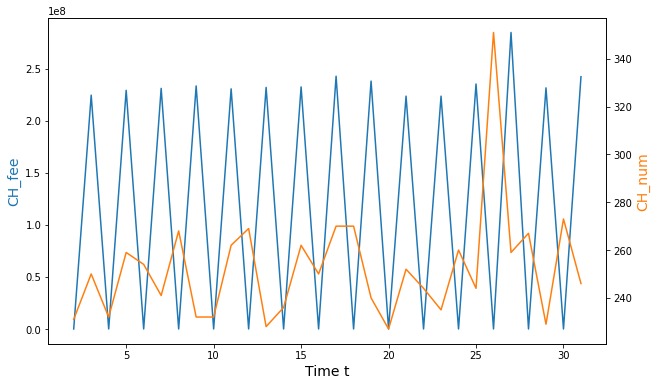

In [ ]:
thesis_data_plot = thesis_output[rand_choice]

thesis_data_plot[["CH_fee", "CH_num"]] = thesis_data_plot[["clearing_house_fee_total", "number_of_batched_payments"]].diff()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

ax.plot(thesis_data_plot.index, thesis_data_plot[['CH_fee']])
ax.set_xlabel('Time t', fontsize='14')
ax.set_ylabel('CH_fee', fontsize='14',color='C0')

ax2 = ax.twinx()
ax2.plot(thesis_data_plot.index, thesis_data_plot[['CH_num']], color='C1')
ax2.set_xlabel('Time t', fontsize='14')
ax2.set_ylabel('CH_num', fontsize='14', color='C1')

# plt.title("Plot of Clearing House", size=20)

fig.savefig('figures/ACH_plot.png')



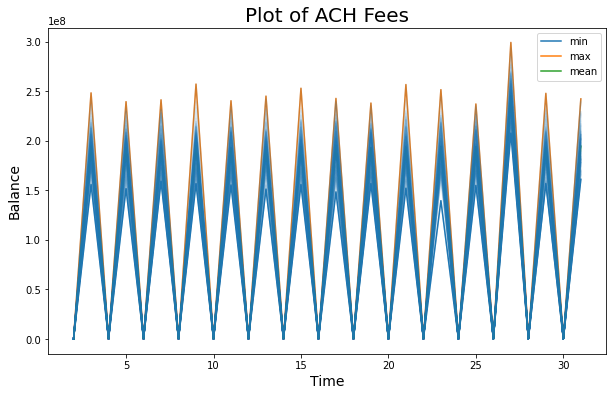

In [ ]:
# Ach Fees Plot
ach_fees = {}
for i, ach in enumerate(thesis_output):
    ach_fees[i] = ach["clearing_house_fee_total"].diff()
ach_fees_df = pd.DataFrame.from_dict(ach_fees)    

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

# Household
ach_fees_df['max'] = ach_fees_df.max(axis=1)
ach_fees_df['min'] = ach_fees_df.min(axis=1)
ach_fees_df['mean'] = ach_fees_df.mean(axis=1)
ax.plot(ach_fees_df.index, ach_fees_df[['min', 'max', 'mean']])
ax.plot(ach_fees_df.index, ach_fees_df, color='C0', alpha=0.1)
ax.set_xlabel('Time', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['min', 'max', 'mean'])
plt.title("Plot of ACH Fees", size=20)

fig.savefig('figures/ACH_fees.png')

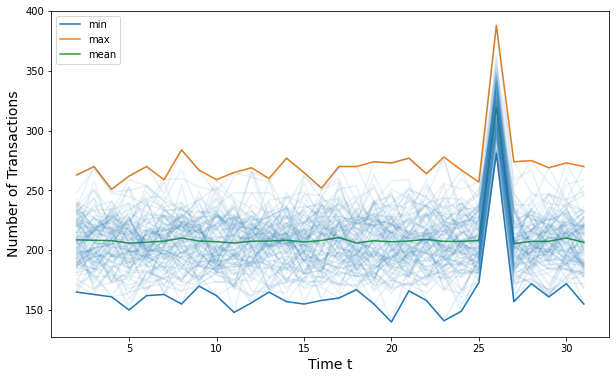

In [ ]:
# Ach Fees Plot
ach_num = {}
for i, ach in enumerate(thesis_output):
    ach_num[i] = ach["number_of_batched_payments"].diff()
ach_num_df = pd.DataFrame.from_dict(ach_num)    

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

# Household
ach_num_df['max'] = ach_num_df.max(axis=1)
ach_num_df['min'] = ach_num_df.min(axis=1)
ach_num_df['mean'] = ach_num_df.mean(axis=1)
ax.plot(ach_num_df.index, ach_num_df[['min', 'max', 'mean']])
ax.plot(ach_num_df.index, ach_num_df, color='C0', alpha=0.1)
ax.set_xlabel('Time t', fontsize='14')
ax.set_ylabel('Number of Transactions', fontsize='14')
ax.legend(['min', 'max', 'mean'], loc=2)
#plt.title("Plot of ACH Num", size=20)

fig.savefig('figures/ACH_num.png')

Number of Clearing House Transactions and Fees

In [ ]:
num_ch = []
for df in thesis_output:
    num_ch.append(int(df["number_of_batched_payments"][-1::]))
num_ch.sort()
num_ch_stats = {}
num_ch_stats["min"] = num_ch[0]
num_ch_stats["max"] = num_ch[-1]
num_ch_stats["mean"] = sum(num_ch)/len(num_ch)
num_ch_stats

{'min': 5553, 'max': 64633, 'mean': 28817.15}

CH Fees

In [ ]:
fees_ch = []
for df in thesis_output:
    fees_ch.append(int(df["clearing_house_fee_total"][-1::]))
fees_ch.sort()
fees_ch_stats = {}
fees_ch_stats["min"] = fees_ch[0]
fees_ch_stats["max"] = fees_ch[-1]
fees_ch_stats["mean"] = sum(fees_ch)/len(fees_ch)
fees_ch_stats

{'min': 2591401851, 'max': 30162088211, 'mean': 13448012939.05}

### Households

In [ ]:
hh_npv = []
for item in households_output:
    hh_ids = list(json_to_dataframe_account(item, num_sim, "loans").columns)
    for house in hh_ids:
        household_npv = json_to_dataframe_id(item, num_sim, house)
        household_npv['npv'] = household_npv[['deposits', 'bank_notes',  'receivables',  'equity_firm' , 'equity_bank']].sum(axis=1) - household_npv['deposits'].values
        hh_npv.append(household_npv)

In [ ]:
hh_npv_rand = []
hh_ids = list(json_to_dataframe_account(households_output[rand_choice], num_sim, "loans").columns)
for house in hh_ids:
    household_npv = json_to_dataframe_id(households_output[rand_choice], num_sim, house)
    household_npv['npv'] = household_npv[['deposits', 'bank_notes',  'receivables',  'equity_firm' , 'equity_bank']].sum(axis=1) - household_npv['deposits'].values
    hh_npv_rand.append(household_npv)

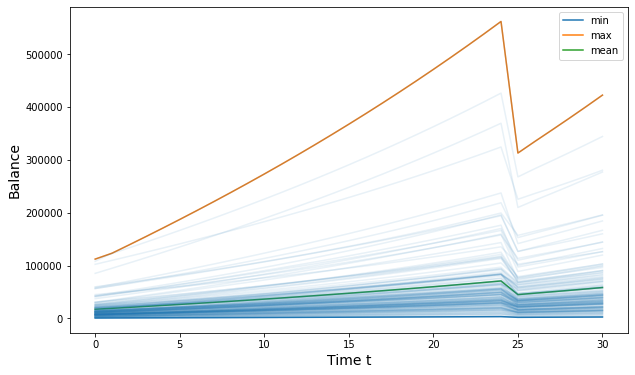

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

household_npv_individual = {}

for i, item in enumerate(hh_npv_rand):
    household_npv_individual[i] = item["npv"]

household_npv_df = pd.DataFrame.from_dict(household_npv_individual)/20000
household_npv_df['max'] = household_npv_df.max(1)
household_npv_df['mean'] = household_npv_df.mean(1)
household_npv_df['min'] = household_npv_df.min(1)

ax.plot(household_npv_df.index, household_npv_df[['min', 'max', 'mean']])
ax.plot(household_npv_df.index, household_npv_df, color='C0', alpha=0.1)
ax.set_xlabel('Time t', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['min', 'max', 'mean'])
# plt.title("Plot of Household NPV", size=20)

fig.savefig('figures/Households_NPVs.png')


Household NPV

In [ ]:
hh_npv_final = []
for item in hh_npv:
    hh_npv_final.append(float(item["npv"][-1:]))
    
hh_npv_stats = {}
hh_npv_final.sort()
hh_npv_stats["min"] = round(hh_npv_final[0], 3)
hh_npv_stats["max"] = round(hh_npv_final[-1], 3)
hh_npv_stats["mean"] = round((sum(hh_npv_final)/len(hh_npv_final)), 3)
hh_npv_stats

{'min': 39576351.992, 'max': 14807396336.176, 'mean': 1086985929.001}

Household Percentage Change NPV

In [ ]:
hh_npv_perc = []
for item in hh_npv:
    hh_npv_perc_hh = (float(item['npv'][-1:]) - float(item['npv'][0]))/item['npv'][0]
    hh_npv_perc.append(hh_npv_perc_hh)

hh_npv_perc_stats = {}
hh_npv_perc.sort()
hh_npv_perc_stats["min"] = round(hh_npv_perc[0], 3)
hh_npv_perc_stats["max"] = round(hh_npv_perc[-1], 3)
hh_npv_perc_stats["mean"] = round((sum(hh_npv_perc)/len(hh_npv_perc)), 3)
hh_npv_perc_stats

{'min': 1.408, 'max': 3.827, 'mean': 2.334}

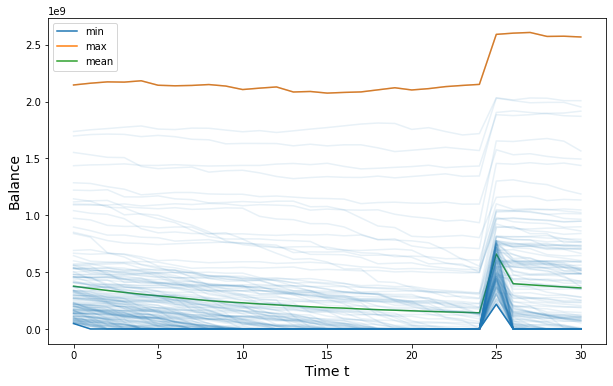

In [ ]:
# Household Deposits Plot
household_deposits = {}
for i, household in enumerate(households_output):
    df_household_deposits = json_to_dataframe_account(household, num_sim, "deposits")
    for j, col in enumerate(df_household_deposits):
        household_deposits[(i+1)*(j+1)] = df_household_deposits[col].values/20000
household_deposits = pd.DataFrame.from_dict(household_deposits)    

household_deposits = json_to_dataframe_account(households_output[rand_choice], num_sim, "deposits")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

# Household
household_deposits['max'] = household_deposits.max(axis=1)
household_deposits['min'] = household_deposits.min(axis=1)
household_deposits['mean'] = household_deposits.mean(axis=1)
ax.plot(household_deposits.index, household_deposits[['min', 'max', 'mean']])
ax.plot(household_deposits.index, household_deposits, color='C0', alpha=0.1)
ax.set_xlabel('Time t', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['min', 'max', 'mean'])
# plt.title("Plot of Household deposits", size=20)

fig.savefig('figures/Households_deposits.png')

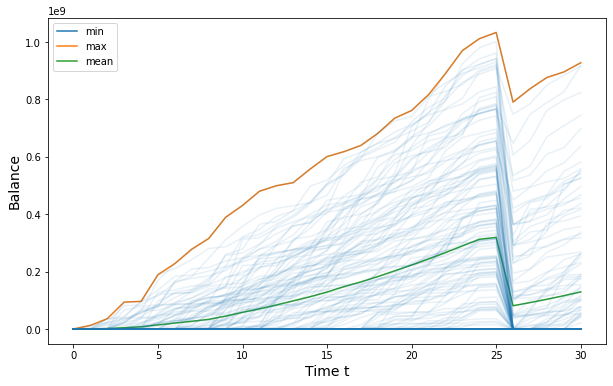

In [ ]:
# Household Loans Plot
household_loans = {}
for i, household in enumerate(households_output):
    df_household_loans = json_to_dataframe_account(household, num_sim, "loans")
    for j, col in enumerate(df_household_deposits):
        household_loans[(i+1)*(j+1)] = df_household_loans[col].values/20000
household_loans = pd.DataFrame.from_dict(household_loans)    

household_loans = json_to_dataframe_account(households_output[rand_choice], num_sim, "loans")
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

# Household
household_loans['max'] = household_loans.max(axis=1)
household_loans['min'] = household_loans.min(axis=1)
household_loans['mean'] = household_loans.mean(axis=1)
ax.plot(household_loans.index, household_loans[['min', 'max', 'mean']])
ax.plot(household_loans.index, household_loans, color='C0', alpha=0.1)
ax.set_xlabel('Time t', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['min', 'max', 'mean'], loc=2)
# plt.title("Plot of Household Loans", size=20)

fig.savefig('figures/Households_loans.png')

## Firms

In [ ]:
firm_eq = []
for firm in firms_output:
    df_firm_eq = json_to_dataframe_account(firm, num_sim, 'equity')
    firm_eq += list((df_firm_eq.iloc[-1,:] - df_firm_eq.iloc[0,:])/df_firm_eq.iloc[0,:])
    
firm_eq_stats = {}
firm_eq.sort()
firm_eq_stats["min"] = round(firm_eq[0], 3)
firm_eq_stats["max"] = round(firm_eq[-1], 3)
firm_eq_stats["mean"] = round((sum(firm_eq)/len(firm_eq)), 3)
firm_eq_stats

{'min': -0.425, 'max': 1.481, 'mean': 0.528}

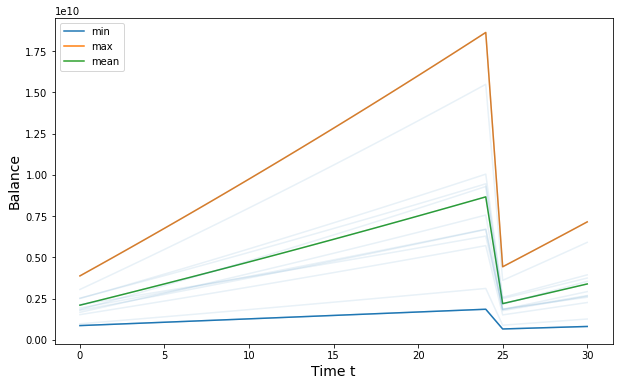

In [ ]:
# Firm Equity Plot
firm_equity = {}
for i, firm in enumerate(firms_output):
    df_firm_equity = json_to_dataframe_account(firm, num_sim, "equity")
    for j, col in enumerate(df_firm_equity):
        firm_equity[(i+1)*(j+1)] = df_firm_equity[col].values
firm_equity = pd.DataFrame.from_dict(firm_equity)    

firm_equity = json_to_dataframe_account(firms_output[rand_choice], num_sim, "equity")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

# Firms
firm_equity['max'] = firm_equity.max(axis=1)
firm_equity['min'] = firm_equity.min(axis=1)
firm_equity['mean'] = firm_equity.mean(axis=1)
ax.plot(firm_equity.index, firm_equity[['min', 'max', 'mean']])
ax.plot(firm_equity.index, firm_equity, color='C0', alpha=0.1)

ax.set_xlabel('Time t', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['min', 'max', 'mean'], loc=2)
# plt.title("Plot of Firm Equity", size=20)

fig.savefig('figures/Firm_Equity.png')

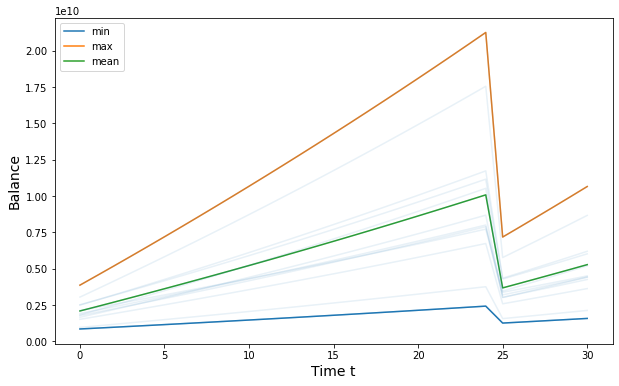

In [ ]:
# Firm Deposits Plot
firm_deposits = {}
for i, firm in enumerate(firms_output):
    df_firm_deposits = json_to_dataframe_account(firm, num_sim, "deposits")
    for j, col in enumerate(df_firm_deposits):
        firm_deposits[(i+1)*(j+1)] = df_firm_deposits[col].values
firm_deposits = pd.DataFrame.from_dict(firm_deposits)    

firm_deposits = json_to_dataframe_account(firms_output[rand_choice], num_sim, "deposits")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

# Firms
firm_deposits['max'] = firm_deposits.max(axis=1)
firm_deposits['min'] = firm_deposits.min(axis=1)
firm_deposits['mean'] = firm_deposits.mean(axis=1)
ax.plot(firm_deposits.index, firm_deposits[['min', 'max', 'mean']])
ax.plot(firm_deposits.index, firm_deposits, color='C0', alpha=0.1)

ax.set_xlabel('Time t', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['min', 'max', 'mean'], loc=2)
#plt.title("Plot of Firm Deposits", size=20)

fig.savefig('figures/Firm_Deposits.png')

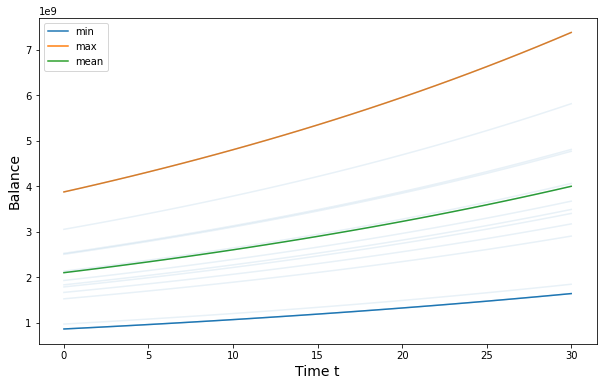

In [ ]:
# Firm Loans Plot
firm_loans = {}
for i, firm in enumerate(firms_output):
    df_firm_loans = json_to_dataframe_account(firm, num_sim, "loans")
    for j, col in enumerate(df_firm_deposits):
        firm_loans[(i+1)*(j+1)] = df_firm_loans[col].values
firm_loans = pd.DataFrame.from_dict(firm_loans)    

firm_loans = json_to_dataframe_account(firms_output[rand_choice], num_sim, "loans")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

# Firms
firm_loans['max'] = firm_loans.max(axis=1)
firm_loans['min'] = firm_loans.min(axis=1)
firm_loans['mean'] = firm_loans.mean(axis=1)
ax.plot(firm_loans.index, firm_loans[['min', 'max', 'mean']])
ax.plot(firm_loans.index, firm_loans, color='C0', alpha=0.1)

ax.set_xlabel('Time t', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['min', 'max', 'mean'], loc=2)
#plt.title("Plot of Firm Loans", size=20)

fig.savefig('figures/Firm_Loans.png')

## Banks

In [ ]:
bank_eq = []
for bank in banks_output:
    df_bank_eq = json_to_dataframe_account(bank, num_sim, 'equity')
    bank_eq += list((df_bank_eq.iloc[-1,:] - df_bank_eq.iloc[0,:])/df_bank_eq.iloc[0,:])
    
bank_eq_stats = {}
bank_eq.sort()
bank_eq_stats["min"] = round(bank_eq[0], 3)
bank_eq_stats["max"] = round(bank_eq[-1], 3)
bank_eq_stats["mean"] = round((sum(bank_eq)/len(bank_eq)), 3)
bank_eq_stats

{'min': 2.787, 'max': 6.174, 'mean': 4.054}

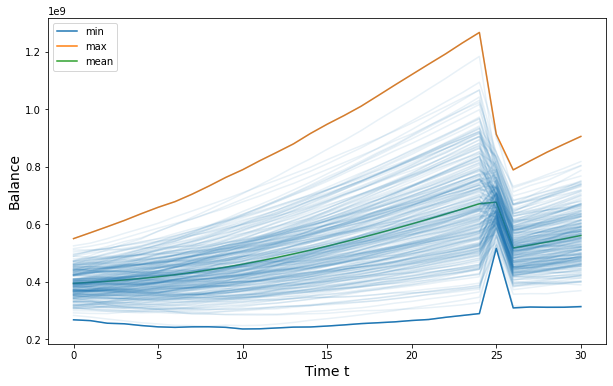

In [ ]:
# Bank Reserves
bank_reserves = {}

for i, bank in enumerate(banks_output):
    df_bank_reserves = json_to_dataframe_account(bank, num_sim, "reserves")
    for j, col in enumerate(df_bank_reserves):
        bank_reserves[(i+1)*(j+1)] = df_bank_reserves[col].values
bank_reserves = pd.DataFrame.from_dict(bank_reserves)    
    

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
bank_reserves["min"] = bank_reserves.min(axis = 1)
bank_reserves["max"] = bank_reserves.max(axis = 1)
bank_reserves["mean"] = bank_reserves.mean(axis = 1)
ax.plot(bank_reserves.index, bank_reserves[["min", "max", "mean"]])
ax.plot(bank_reserves.index, bank_reserves, color = "C0", alpha = 0.1)

ax.set_xlabel('Time t', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['min', 'max', 'mean'], loc=2)
#plt.title("Plot of Reserves", size=20)

fig.savefig('figures/Bank_Reserves.png')

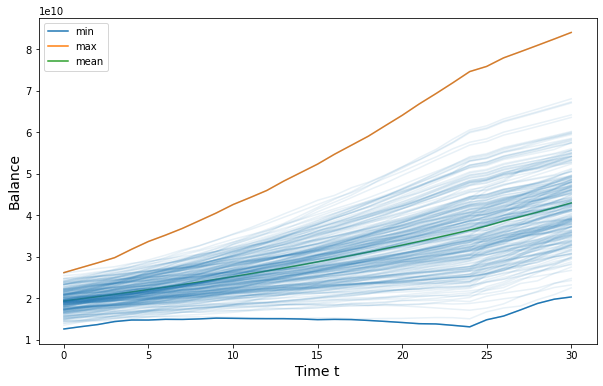

In [ ]:
# Bank OMO
bank_omo = {}

for i, bank in enumerate(banks_output):
    df_bank_omo = json_to_dataframe_account(bank, num_sim, "open_market_operations")
    for j, col in enumerate(df_bank_reserves):
        bank_omo[(i+1)*(j+1)] = df_bank_omo[col].values
bank_omo = pd.DataFrame.from_dict(bank_omo)    
    

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
bank_omo["min"] = bank_omo.min(axis = 1)
bank_omo["max"] = bank_omo.max(axis = 1)
bank_omo["mean"] = bank_omo.mean(axis = 1)
ax.plot(bank_omo.index, bank_omo[["min", "max", "mean"]])
ax.plot(bank_omo.index, bank_omo, color = "C0", alpha = 0.1)

ax.set_xlabel('Time t', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['min', 'max', 'mean'], loc=2)
#plt.title("Plot of Reserves", size=20)


fig.savefig('figures/Bank_OMO.png')

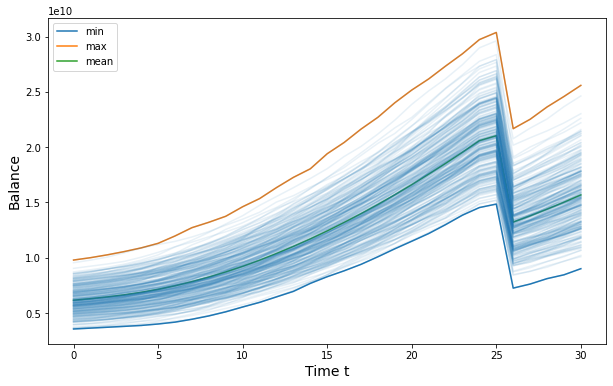

In [ ]:
# Bank Loans
bank_loans = {}

for i, bank in enumerate(banks_output):
    df_bank_loans = json_to_dataframe_account(bank, num_sim, "loans")
    for j, col in enumerate(df_bank_loans):
        bank_loans[(i+1)*(j+1)] = df_bank_loans[col].values
bank_loans = pd.DataFrame.from_dict(bank_loans)    
    

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
bank_loans["min"] = bank_loans.min(axis = 1)
bank_loans["max"] = bank_loans.max(axis = 1)
bank_loans["mean"] = bank_loans.mean(axis = 1)
ax.plot(bank_loans.index, bank_loans[["min", "max", "mean"]])
ax.plot(bank_loans.index, bank_loans, color = "C0", alpha = 0.1)

ax.set_xlabel('Time t', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['min', 'max', 'mean'], loc=2)
#plt.title("Plot of Reserves", size=20)


fig.savefig('figures/Bank_Loans.png')

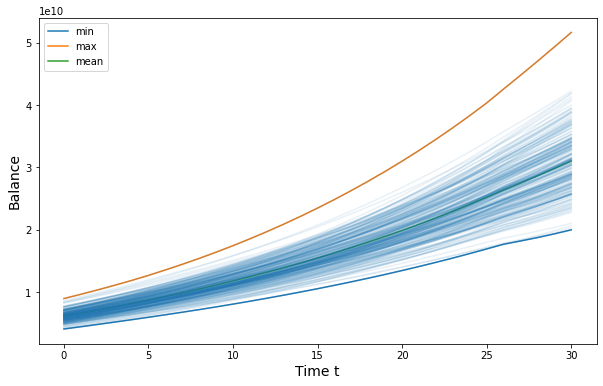

In [ ]:
# Interbank Loans
bank_equity = {}

for i, bank in enumerate(banks_output):
    df_bank_equity = json_to_dataframe_account(bank, num_sim, "equity")
    for j, col in enumerate(df_bank_equity):
        bank_equity[(i+1)*(j+1)] = df_bank_equity[col].values
bank_equity = pd.DataFrame.from_dict(bank_equity)    
    

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
bank_equity["min"] = bank_equity.min(axis = 1)
bank_equity["max"] = bank_equity.max(axis = 1)
bank_equity["mean"] = bank_equity.mean(axis = 1)
ax.plot(bank_equity.index, bank_equity[["min", "max", "mean"]])
ax.plot(bank_equity.index, bank_equity, color = "C0", alpha = 0.1)

ax.set_xlabel('Time t', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['min', 'max', 'mean'])
# plt.title("Plot of Bank Equity", size=20)


fig.savefig('figures/Bank_Equity.png')

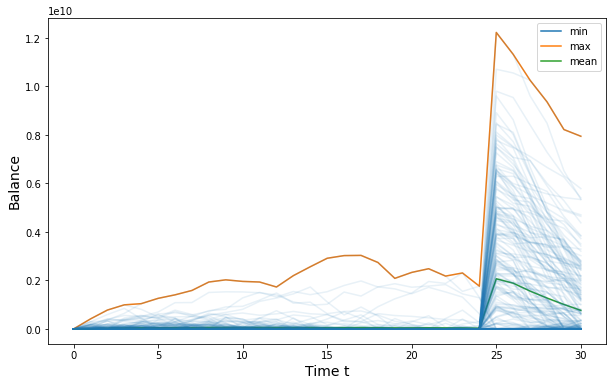

In [ ]:
# Interbank Loans
bank_interbank_loans = {}

for i, bank in enumerate(banks_output):
    df_bank_interbank_loans = json_to_dataframe_account(bank, num_sim, "interbank_loans")
    for j, col in enumerate(df_bank_interbank_loans):
        bank_interbank_loans[(i+1)*(j+1)] = df_bank_interbank_loans[col].values
bank_interbank_loans = pd.DataFrame.from_dict(bank_interbank_loans)    
    

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
bank_interbank_loans["min"] = bank_interbank_loans.min(axis = 1)
bank_interbank_loans["max"] = bank_interbank_loans.max(axis = 1)
bank_interbank_loans["mean"] = bank_interbank_loans.mean(axis = 1)
ax.plot(bank_interbank_loans.index, bank_interbank_loans[["min", "max", "mean"]])
ax.plot(bank_interbank_loans.index, bank_interbank_loans, color = "C0", alpha = 0.1)

ax.set_xlabel('Time t', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['min', 'max', 'mean'])
# plt.title("Plot of Interbank Loans", size=20)


fig.savefig('figures/IB_Loans.png')

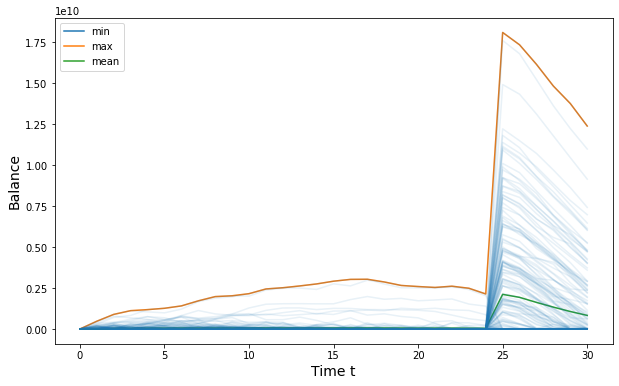

In [ ]:
num_sim = int(parameter_values[0][1])
bank_loans_interbank_bank_id = {}

for i, bank in enumerate(banks_output):
    # df_bank_reserves = json_to_dataframe_account(bank, num_sim, "deposits")
    df = bank
    account = 'loans_interbank'
    # Function that creates dataframe where columns are a specific account type for each agent of certain type for each simulation step
    # i.e: cols = [bank_0_deposits, bank_1_deposits, ..., bank_n_deposits]
    #def json_to_dataframe_account(df, num_sim, account):
    df_new = pd.DataFrame() # Create empty df
    for item in df: # Loop through list of output from entire step
        balance_h = {} # Create empty list to store balance sheets
        for j in list(item.values()): # Loop through list of agents
            for k in j: # Loop through individual agents
                for h in k:
                    for v in k[h].values():
                        try:
                            balance_h[h] = v[account + "_" + h]   
                        except:
                            pass
        agent_bal = pd.DataFrame([balance_h]) # Create df of balance sheet
        df_new = pd.concat([df_new, agent_bal]) # Concat current step total to previous step output rowwise
    df_new.index = range(num_sim) # Reindex to number of steps

    #return df_new 

    for j, col in enumerate(df_new):
        bank_loans_interbank_bank_id[(i+1)*(j+1)] = df_new[col].values
bank_loans_interbank_bank_id = pd.DataFrame.from_dict(bank_loans_interbank_bank_id) 
bank_loans_interbank_bank_id  



fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
bank_loans_interbank_bank_id["min"] = bank_loans_interbank_bank_id.min(axis = 1)
bank_loans_interbank_bank_id["max"] = bank_loans_interbank_bank_id.max(axis = 1)
bank_loans_interbank_bank_id["mean"] = bank_loans_interbank_bank_id.mean(axis = 1)
ax.plot(bank_loans_interbank_bank_id.index, bank_loans_interbank_bank_id[["min", "max", "mean"]])
ax.plot(bank_loans_interbank_bank_id.index, bank_loans_interbank_bank_id, color = "C0", alpha = 0.1)

ax.set_xlabel('Time t', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['min', 'max', 'mean'], loc=2)
#plt.title("Plot of Reserves", size=20)


fig.savefig('figures/Bank_Loans_IB_Bank_ID.png')

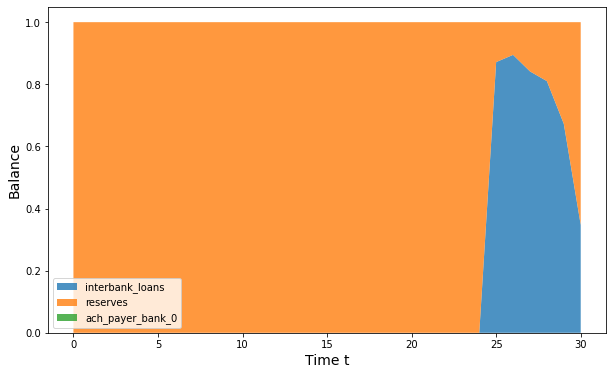

In [ ]:
df_bank_0 = json_to_dataframe_id(banks_output[0], num_sim, 'bank_0')

df_bank_plot = df_bank_0[['interbank_loans', 'reserves', 'ach_payer_bank_0']] + 0.01
df_bank_plot = df_bank_plot.divide(df_bank_plot.sum(1), 0)


df_bank_plot_dict = df_bank_plot.to_dict()

for key in df_bank_plot_dict.keys():
    df_bank_plot_dict[key] = list(df_bank_plot_dict[key].values())

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
ax.stackplot(df_bank_0.index, df_bank_plot_dict.values(),labels=df_bank_plot_dict.keys(), alpha = 0.8)
ax.set_xlabel('Time t', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(df_bank_plot.columns, loc=3)
# plt.title("Area Plot of Selected Bank_0 Assets", size=20)

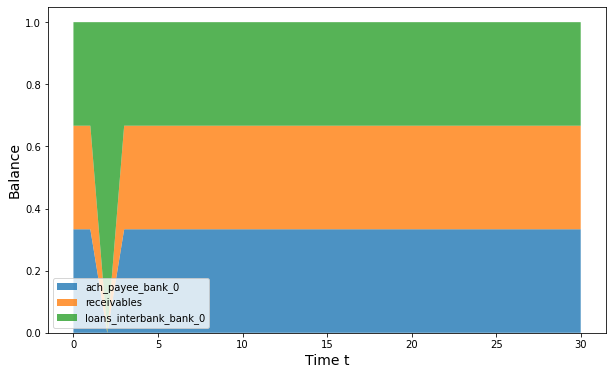

In [ ]:
df_bank_plot = df_bank_0[['ach_payee_bank_0', 'receivables', 'loans_interbank_bank_0']] + 0.01
df_bank_plot = df_bank_plot.divide(df_bank_plot.sum(1), 0)


df_bank_plot_dict = df_bank_plot.to_dict()

for key in df_bank_plot_dict.keys():
    df_bank_plot_dict[key] = list(df_bank_plot_dict[key].values())

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
ax.stackplot(df_bank_0.index, df_bank_plot_dict.values(),labels=df_bank_plot_dict.keys(), alpha =0.8)
ax.set_xlabel('Time t', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(df_bank_plot.columns, loc=3)
# plt.title("Area Plot of Selected Bank_0 Liabilities", size=20)


## Central Bank

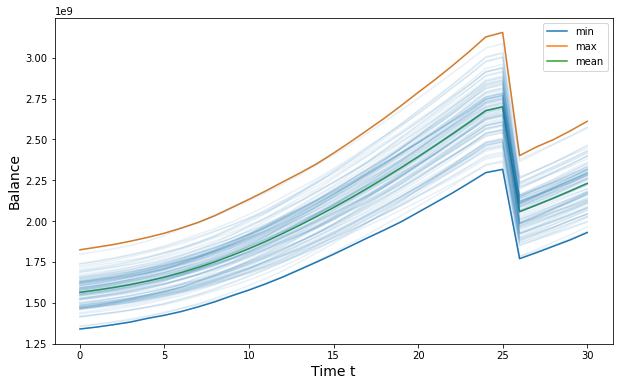

In [ ]:
# Interbank Loans
central_bank_reserves = {}

for i, cb in enumerate(central_bank_output):
    df_central_bank_reserves = json_to_dataframe_account(cb, num_sim, "reserves")
    central_bank_reserves[i] = df_central_bank_reserves['central_bank'].values
central_bank_reserves = pd.DataFrame.from_dict(central_bank_reserves)    
    

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
central_bank_reserves["min"] = central_bank_reserves.min(axis = 1)
central_bank_reserves["max"] = central_bank_reserves.max(axis = 1)
central_bank_reserves["mean"] = central_bank_reserves.mean(axis = 1)
ax.plot(central_bank_reserves.index, central_bank_reserves[["min", "max", "mean"]])
ax.plot(central_bank_reserves.index, central_bank_reserves, color = "C0", alpha = 0.1)
ax.set_xlabel('Time t', fontsize='14')
ax.set_ylabel('Reserves', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['min', 'max', 'mean'])

# plt.title("Plot of Central Bank Reserves Sheet", size=20)

fig.savefig('figures/CB_reserves.png')

In [ ]:
cb_res = []
for central_bank in central_bank_output:
    df_cb_res = json_to_dataframe_account(central_bank, num_sim, 'reserves')
    cb_res += list((df_cb_res.iloc[-1,:] - df_cb_res.iloc[0,:])/df_cb_res.iloc[0,:])
    
df_cb_res_stats = {}
cb_res.sort()
df_cb_res_stats["min"] = round(cb_res[0], 3)
df_cb_res_stats["max"] = round(cb_res[-1], 3)
df_cb_res_stats["mean"] = round((sum(cb_res)/len(cb_res)), 3)
df_cb_res_stats

{'min': 0.353, 'max': 0.541, 'mean': 0.427}

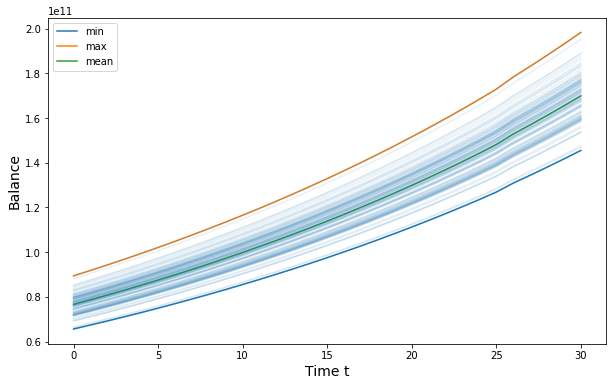

In [ ]:
# Interbank Loans
central_bank_omo = {}

for i, cb in enumerate(central_bank_output):
    df_central_bank_omo = json_to_dataframe_account(cb, num_sim, "open_market_operations")
    central_bank_omo[i] = df_central_bank_omo['central_bank'].values
central_bank_omo = pd.DataFrame.from_dict(central_bank_omo)    
    

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
central_bank_omo["min"] = central_bank_omo.min(axis = 1)
central_bank_omo["max"] = central_bank_omo.max(axis = 1)
central_bank_omo["mean"] = central_bank_omo.mean(axis = 1)
ax.plot(central_bank_omo.index, central_bank_omo[["min", "max", "mean"]])
ax.plot(central_bank_omo.index, central_bank_omo, color = "C0", alpha = 0.1)
ax.set_xlabel('Time t', fontsize='14')
ax.set_ylabel('Reserves', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['min', 'max', 'mean'])

# plt.title("Plot of Central Bank OMO", size=20)

fig.savefig('figures/CB_OMO.png')

In [ ]:
cb_omo = []
for central_bank in central_bank_output:
    df_cb_omo = json_to_dataframe_account(central_bank, num_sim, 'open_market_operations')
    cb_omo += list((df_cb_omo.iloc[-1,:] - df_cb_omo.iloc[0,:])/df_cb_omo.iloc[0,:])
    
df_cb_omo_stats = {}
cb_omo.sort()
df_cb_omo_stats["min"] = round(cb_omo[0], 3)
df_cb_omo_stats["max"] = round(cb_omo[-1], 3)
df_cb_omo_stats["mean"] = round((sum(cb_omo)/len(cb_omo)), 3)
df_cb_omo_stats

{'min': 1.214, 'max': 1.22, 'mean': 1.217}

## Plot Network structures

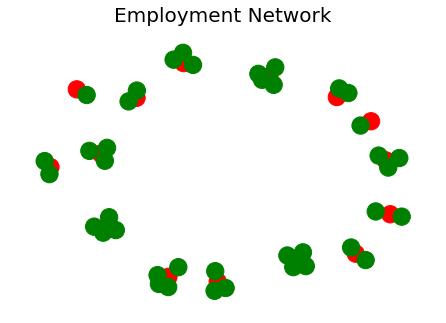

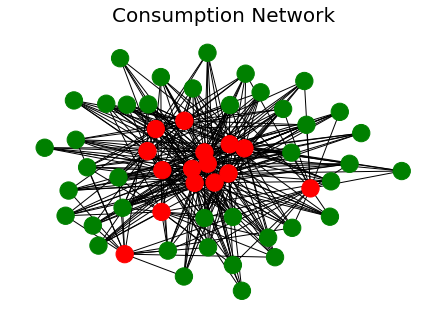

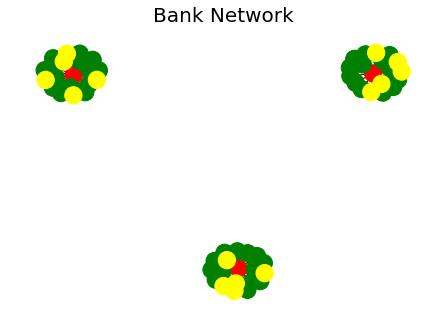

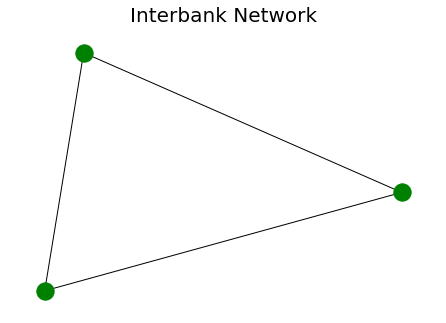

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
# Plot employment network    
E = environment.employment_network
color_map_E = ['red' if "firm" in node else 'green' for node in E]        
nx.draw(E, node_color=color_map_E)
plt.title("Employment Network", size=20)
plt.savefig('figures/employment_network.png')
plt.show()
# Plot consumption network
C = environment.consumption_network
color_map_C = ['red' if "firm" in node else 'green' for node in C]        
nx.draw(C, node_color=color_map_C)
plt.title("Consumption Network", size=20)
plt.savefig('figures/consumption_network.png')
plt.show()
# Plot bank network
B = environment.bank_network
color_map_B = ['red' if "bank" in node else 'yellow' if "firm" in node else 'green' for node in B]        
nx.draw(B, node_color=color_map_B)
plt.title("Bank Network", size=20)
plt.savefig('figures/bank_network.png')
plt.show()
# Plot interbank network
I = environment.interbank_network    
nx.draw(I, node_color="g")
plt.title("Interbank Network", size=20)
plt.savefig('figures/interbank_network.png')
plt.show()
